### Library Import

In [20]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

### Data Load

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 파일 호출
data_path: str = "/content/drive/MyDrive/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [6]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:06<00:00, 15.89it/s]


### 거래소별 EDA

거래소 간 지표들의 차이들이 유효한지 확인하기 위한 기본적인 EDA를 진행합니다. 여기서는 거래소가 여러개이기 때문에 renaming을 진행하지 않고 raw name으로 진행하겠습니다. target은 _type이 train인 항목에만 존재하기 때문에 train_df에 별도로 할당해 진행하겠습니다.

In [7]:
train_df = df.loc[df["_type"]=="train"]

In [9]:
train_df.shape

(8760, 255)

기본적인 지표로 활용될 수 있는 피쳐의 개수는 30여개인데 반해 train_df에 있는 column 의 개수는 200개가 넘습니다. target별 거래소간 차이가 유의미하다면 모델에 들어가야 되지만 유의미하지 않다면 필요없는 피쳐를 많이 줄일 수 있습니다. 거래소별 data가 있는 칼럼으로는 **Funding-rates**, **Liquidations(Long and Short)**, **Open-interest**, **Taker-Buy-Sell-Stats**가 있습니다.

#### Funding rates

In [10]:
column = [col for col in train_df.columns if 'funding' in col]
column

['hourly_market-data_funding-rates_all_exchange_funding_rates',
 'hourly_market-data_funding-rates_okx_funding_rates',
 'hourly_market-data_funding-rates_bybit_funding_rates',
 'hourly_market-data_funding-rates_htx_global_funding_rates',
 'hourly_market-data_funding-rates_huobi_global_funding_rates',
 'hourly_market-data_funding-rates_deribit_funding_rates',
 'hourly_market-data_funding-rates_bitmex_funding_rates',
 'hourly_market-data_funding-rates_binance_funding_rates',
 'hourly_market-data_funding-rates_okex_funding_rates']

In [18]:
 # 'funding' 이 들어간 모든 column 추출
funding_columns = [col for col in train_df.columns if 'funding' in col]

# 거래소별로 funding rates에 따른 target 통계량 확인
# groupby를 사용하여 거래소와 target 값을 기준으로 funding_rates의 통계량을 계산

for col in funding_columns:
    print(f"Funding Rates: {col}")

    # 거래소와 target별로 funding_rates의 통계량 (평균, 중앙값, 표준편차 등) 계산
    stats = train_df.groupby(['target'])[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

    # 통계량 확인
    print(stats)


Funding Rates: hourly_market-data_funding-rates_all_exchange_funding_rates
   target      mean    median       std       min       max  count
0     0.0  0.007483  0.007692  0.011701 -0.088336  0.057161    740
1     1.0  0.007194  0.006475  0.010103 -0.096779  0.066757   3544
2     2.0  0.007192  0.006554  0.010587 -0.097568  0.067024   3671
3     3.0  0.006617  0.007310  0.012635 -0.092518  0.061188    805
Funding Rates: hourly_market-data_funding-rates_okx_funding_rates
   target      mean    median       std       min       max  count
0     0.0  0.007001  0.006538  0.021057 -0.198395  0.093827    739
1     1.0  0.005630  0.005049  0.017700 -0.198395  0.093827   3544
2     2.0  0.005277  0.005059  0.018217 -0.198395  0.093827   3671
3     3.0  0.006078  0.005936  0.020752 -0.124474  0.093827    805
Funding Rates: hourly_market-data_funding-rates_bybit_funding_rates
   target      mean  median       std       min       max  count
0     0.0  0.007543    0.01  0.015493 -0.158533  0.04750

All exchanges 와 다른 거래소 funding rates를 비교했을 때 통계량에서, 특히나 mean과 standard deviation에서 큰 차이가 없음을 확인할 수 있습니다. 따라서 funding rates 의 경우, all exchanges 하나만 피쳐에 넣는 것과 모든 거래소의 funding rates를 넣는 것이 큰 차이가 없음을 확인할 수 있습니다.

<ipython-input-22-3593bbeafd73>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='funding_rate', y='spearman_corr', palette='Blues')
<ipython-input-22-3593bbeafd73>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


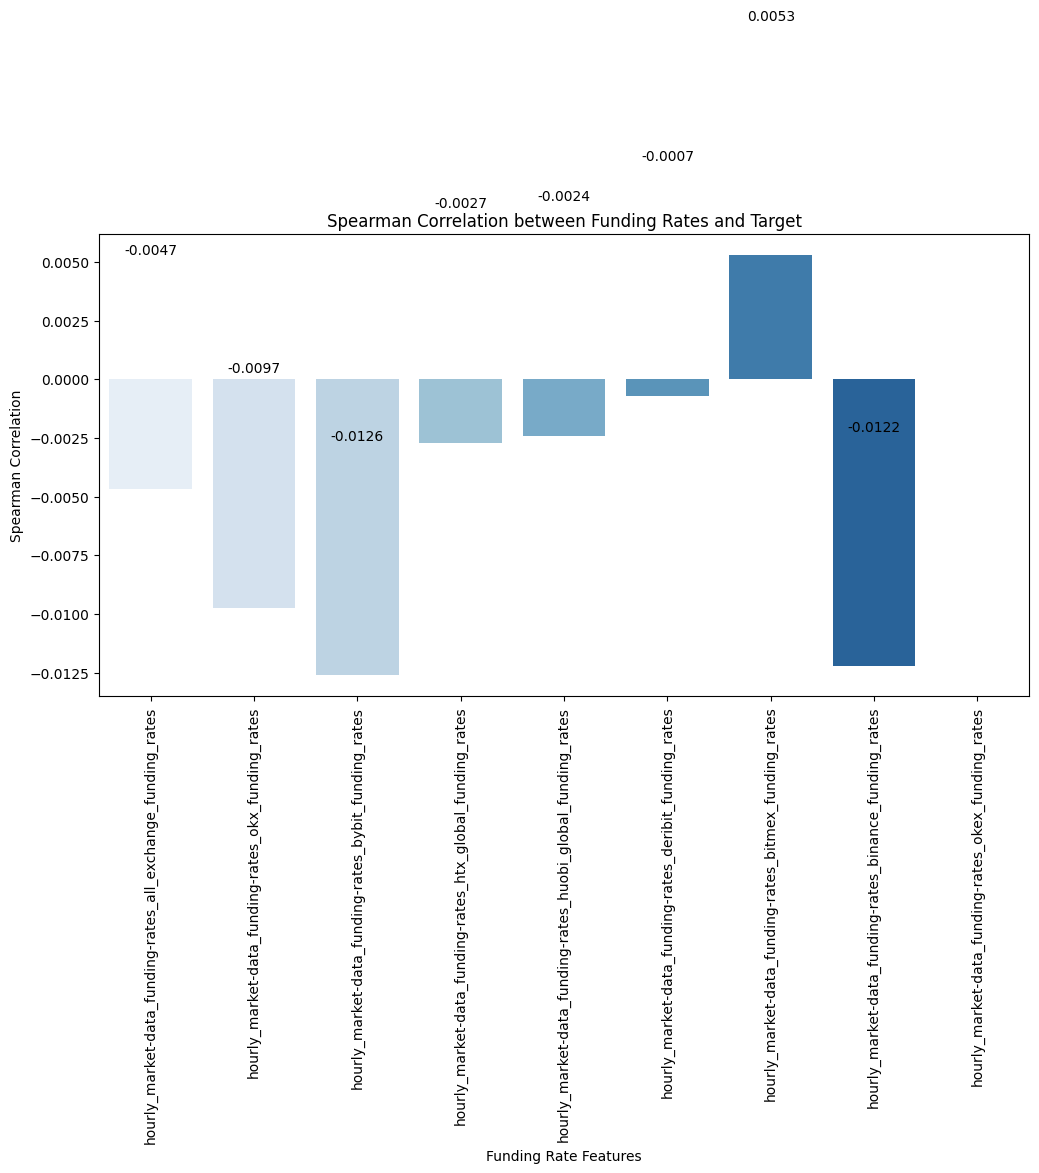

In [22]:
# Spearman 상관계수 계산
correlations = {}

for col in funding_columns:
    # spearman 상관계수 계산 (target 과 funding_rates)
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 상관계수를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['funding_rate', 'spearman_corr'])

# 상관계수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=corr_df, x='funding_rate', y='spearman_corr', palette='Blues')

# 각 막대 위에 상관계수 값을 표시
for index, row in corr_df.iterrows():
    plt.text(index, row.spearman_corr + 0.01, round(row.spearman_corr, 4), color='black', ha="center")

plt.xticks(rotation=90)
plt.title('Spearman Correlation between Funding Rates and Target')
plt.ylabel('Spearman Correlation')
plt.xlabel('Funding Rate Features')
plt.tight_layout()

# 시각화 출력
plt.show()

위의 상관계수 차트를 확인해도 모든 거래소의 funding rates를 넣어 유의미한 결과를 얻을 수 없다는 결론을 낼 수 있습니다.

#### Liquidations

##### Long Liquidations

In [12]:
column = [col for col in train_df.columns if 'long_liquidation' in col]
column

['hourly_market-data_liquidations_binance_btc_usdt_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd',
 'hourly_market-data_liquidations_bitfinex_btc_usdt_long_liquidations',
 'hourly_market-data_liquidations_bitfinex_btc_usdt_long_liquidations_usd',
 'hourly_market-data_liquidations_binance_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
 'hourly_market-data_liquida

위의 결과에서 확인할 수 있듯이 long liquidations 같은 경우 usd가 포함되어 굉장히 많은 컬럼들이 추가 됩니다. usd 같은 경우 지표를 환율로 나타낸 수치기에 usd가 붙어 있지 않은 column과 correlation이 굉장히 높기 때문에 EDA에서는 제외하겠습니다.

In [26]:
long_liquidation_columns = [col for col in train_df.columns if col.endswith('long_liquidations')]
long_liquidation_columns

['hourly_market-data_liquidations_binance_btc_usdt_long_liquidations',
 'hourly_market-data_liquidations_bitfinex_btc_usdt_long_liquidations',
 'hourly_market-data_liquidations_binance_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
 'hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_okx_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations',
 'hourly_market-data_liquidations_bitmex_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_deribit_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_okx_btc_usdt_long_liquidations',
 'hourly_market-data_liquidations_gate_io_btc_usd_long_liq

In [27]:
# 각 컬럼에 대해 target 별 통계량 계산
for col in long_liquidation_columns:
    print(f"Long Liquidations Column: {col}")

    # target별로 long liquidations 통계량 계산 (평균, 중앙값, 표준편차 등)
    stats = train_df.groupby('target')[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

    # 통계량 출력
    print(stats)
    print("\n")

Long Liquidations Column: hourly_market-data_liquidations_binance_btc_usdt_long_liquidations
   target      mean  median        std  min      max  count
0     0.0  6.510789   1.609  15.340445  0.0  245.282    740
1     1.0  3.160653   0.259   8.689399  0.0  170.178   3542
2     2.0  4.244743   0.567  11.164778  0.0  260.941   3669
3     3.0  8.780432   1.402  26.556191  0.0  517.780    803


Long Liquidations Column: hourly_market-data_liquidations_bitfinex_btc_usdt_long_liquidations
   target      mean  median       std  min         max  count
0     0.0  0.487503     0.0  4.609513  0.0   98.281261    739
1     1.0  0.215315     0.0  3.793954  0.0  159.089863   3544
2     2.0  0.419670     0.0  6.352641  0.0  234.551989   3671
3     3.0  1.138368     0.0  8.837879  0.0  144.561843    805


Long Liquidations Column: hourly_market-data_liquidations_binance_all_symbol_long_liquidations
   target      mean    median        std  min         max  count
0     0.0  7.194947  1.642500  17.80221

long liquidations 관련 칼럼들은 수가 많은 만큼 okex와 ftx에서 NaN값이 발견됨을 확인할 수 있으며 여전히 all_exchange와 다를 바 없이 0과3 에서 평균 수치가 높고 standard deviation 값이 높으며 1과 2에서 평균 수치가 낮고 standard deviation 값이 낮음을 알 수 있습니다.

In [29]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in long_liquidation_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['long_liquidations', 'spearman_corr'])

# 상관계수 출력
print(corr_df)

                                    long_liquidations  spearman_corr
0   hourly_market-data_liquidations_binance_btc_us...       0.051815
1   hourly_market-data_liquidations_bitfinex_btc_u...       0.044813
2   hourly_market-data_liquidations_binance_all_sy...       0.052259
3   hourly_market-data_liquidations_binance_btc_bu...       0.043146
4   hourly_market-data_liquidations_bitfinex_all_s...       0.044813
5   hourly_market-data_liquidations_all_exchange_a...       0.046438
6   hourly_market-data_liquidations_binance_btc_us...       0.048646
7   hourly_market-data_liquidations_huobi_global_a...       0.027852
8   hourly_market-data_liquidations_okx_all_symbol...       0.041114
9   hourly_market-data_liquidations_htx_global_btc...       0.027252
10  hourly_market-data_liquidations_bitmex_all_sym...       0.036355
11  hourly_market-data_liquidations_deribit_all_sy...       0.035846
12  hourly_market-data_liquidations_okx_btc_usdt_l...       0.042306
13  hourly_market-data_liquidation

칼럼의 개수가 많아 시각화보다는 target 값과의 correlation 값을 직접적으로 나타낸게 위의 수치입니다. 5번 all exchange와 다른 거래소들을 비교하면 특출나게 높은 거래소가 없음을 확인할 수 있습니다.

##### Short liquidations

In [30]:
short_liquidation_columns = [col for col in train_df.columns if col.endswith('short_liquidations')]
short_liquidation_columns

['hourly_market-data_liquidations_binance_btc_usdt_short_liquidations',
 'hourly_market-data_liquidations_bitfinex_btc_usdt_short_liquidations',
 'hourly_market-data_liquidations_binance_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_usd_short_liquidations',
 'hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_okx_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations',
 'hourly_market-data_liquidations_bitmex_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_deribit_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_okx_btc_usdt_short_liquidations',
 'hourly_market-data_liquidations_gate_io_btc

In [31]:
# 각 컬럼에 대해 target 별 통계량 계산
for col in short_liquidation_columns:
    print(f"Short Liquidations Column: {col}")

    # target별로 short liquidations 통계량 계산 (평균, 중앙값, 표준편차 등)
    stats = train_df.groupby('target')[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

    # 통계량 출력
    print(stats)
    print("\n")

Short Liquidations Column: hourly_market-data_liquidations_binance_btc_usdt_short_liquidations
   target      mean  median        std  min      max  count
0     0.0  8.002200  1.8925  22.540148  0.0  467.948    740
1     1.0  4.430708  0.7145  10.498179  0.0  212.802   3542
2     2.0  3.848727  0.4820  12.717338  0.0  429.966   3669
3     3.0  7.719441  2.3770  16.117531  0.0  177.257    803


Short Liquidations Column: hourly_market-data_liquidations_bitfinex_btc_usdt_short_liquidations
   target      mean  median        std  min         max  count
0     0.0  1.218644     0.0  11.805761  0.0  180.992756    739
1     1.0  0.377842     0.0   4.494925  0.0  110.521471   3544
2     2.0  0.302677     0.0   4.495725  0.0  179.494149   3671
3     3.0  1.122267     0.0  10.844065  0.0  246.018525    805


Short Liquidations Column: hourly_market-data_liquidations_binance_all_symbol_short_liquidations
   target      mean   median        std  min         max  count
0     0.0  8.960471  1.92500 

short liquidations도 long liquidations 와 같이 target 별 통계량 상 거래소들과 all exchange의 추이가 유의미한 차이가 없음을 알 수 있습니다. 0과 3 에서 mean 과 standard deviation이 높고 1과 2에서 mean과 standard deviation이 낮음을 알 수 있습니다.

In [34]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in short_liquidation_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method = 'spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['short_liquidations', 'spearman_corr'])

# 상관계수 출력
print(corr_df)


                                   short_liquidations  spearman_corr
0   hourly_market-data_liquidations_binance_btc_us...      -0.009087
1   hourly_market-data_liquidations_bitfinex_btc_u...      -0.013057
2   hourly_market-data_liquidations_binance_all_sy...      -0.008977
3   hourly_market-data_liquidations_binance_btc_bu...      -0.025641
4   hourly_market-data_liquidations_bitfinex_all_s...      -0.013057
5   hourly_market-data_liquidations_all_exchange_a...      -0.015096
6   hourly_market-data_liquidations_binance_btc_us...      -0.020071
7   hourly_market-data_liquidations_huobi_global_a...      -0.019423
8   hourly_market-data_liquidations_okx_all_symbol...      -0.020811
9   hourly_market-data_liquidations_htx_global_btc...      -0.020523
10  hourly_market-data_liquidations_bitmex_all_sym...      -0.015187
11  hourly_market-data_liquidations_deribit_all_sy...       0.006238
12  hourly_market-data_liquidations_okx_btc_usdt_s...      -0.020524
13  hourly_market-data_liquidation

correlation 수치도 큰 차이가 없음을 위에서 확인할 수 있습니다

#### Open interest

In [35]:
open_interest_columns = [col for col in train_df.columns if 'open_interest' in col]
open_interest_columns

['hourly_market-data_open-interest_gate_io_all_symbol_open_interest',
 'hourly_market-data_open-interest_deribit_all_symbol_open_interest',
 'hourly_market-data_open-interest_bitfinex_btc_usdt_open_interest',
 'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest',
 'hourly_market-data_open-interest_binance_all_symbol_open_interest',
 'hourly_market-data_open-interest_bitmex_open_interest',
 'hourly_market-data_open-interest_deribit_btc_usd_open_interest',
 'hourly_market-data_open-interest_bitmex_btc_usd_open_interest',
 'hourly_market-data_open-interest_binance_btc_usd_open_interest',
 'hourly_market-data_open-interest_ftx_open_interest',
 'hourly_market-data_open-interest_huobi_global_all_symbol_open_interest',
 'hourly_market-data_open-interest_bybit_btc_usd_open_interest',
 'hourly_market-data_open-interest_binance_btc_usdt_open_interest',
 'hourly_market-data_open-interest_all_exchange_open_interest',
 'hourly_market-data_open-interest_binance_btc_busd_open_inte

In [36]:
# 각 컬럼에 대해 target 별 통계량 계산
for col in open_interest_columns:
    print(f"Open Interest Column: {col}")

    # target별로 open interest 통계량 계산 (평균, 중앙값, 표준편차 등)
    stats = train_df.groupby('target')[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

    # 통계량 출력
    print(stats)
    print("\n")

Open Interest Column: hourly_market-data_open-interest_gate_io_all_symbol_open_interest
   target          mean        median           std           min  \
0     0.0  4.978354e+08  4.879041e+08  1.338474e+08  7.262356e+07   
1     1.0  5.051228e+08  4.828696e+08  1.336066e+08  7.322098e+07   
2     2.0  5.034713e+08  4.828387e+08  1.340490e+08  7.180890e+07   
3     3.0  4.970793e+08  4.842504e+08  1.383407e+08  7.136720e+07   

            max  count  
0  8.394487e+08    739  
1  8.493109e+08   3544  
2  8.443922e+08   3671  
3  8.418059e+08    805  


Open Interest Column: hourly_market-data_open-interest_deribit_all_symbol_open_interest
   target          mean       median           std          min          max  \
0     0.0  5.153914e+08  506721420.0  1.096465e+08  296515900.0  798179790.0   
1     1.0  4.913197e+08  454257580.0  1.171194e+08  287380350.0  801304750.0   
2     2.0  4.944645e+08  455687010.0  1.186531e+08  287414080.0  801211420.0   
3     3.0  5.111838e+08  498871

open interest 또한 all_exchange 대신에 거래소 데이타 각각 column으로 쓸 이유가 없어 보입니다. 거기에 통계량 상으로 target값 별 유의미한 통계량 차이가 없어 보이는 것과 값이 다른 지표에 비해 굉장히 큰 게 특징으로 볼 수 있습니다.

In [37]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in open_interest_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['open_interest', 'spearman_corr'])

# 상관계수 출력
print(corr_df)


                                        open_interest  spearman_corr
0   hourly_market-data_open-interest_gate_io_all_s...      -0.009143
1   hourly_market-data_open-interest_deribit_all_s...       0.002106
2   hourly_market-data_open-interest_bitfinex_btc_...      -0.013186
3   hourly_market-data_open-interest_all_exchange_...      -0.019518
4   hourly_market-data_open-interest_binance_all_s...      -0.024763
5   hourly_market-data_open-interest_bitmex_open_i...            NaN
6   hourly_market-data_open-interest_deribit_btc_u...       0.002106
7   hourly_market-data_open-interest_bitmex_btc_us...      -0.012657
8   hourly_market-data_open-interest_binance_btc_u...      -0.021217
9   hourly_market-data_open-interest_ftx_open_inte...            NaN
10  hourly_market-data_open-interest_huobi_global_...      -0.013428
11  hourly_market-data_open-interest_bybit_btc_usd...      -0.020753
12  hourly_market-data_open-interest_binance_btc_u...      -0.020266
13  hourly_market-data_open-intere

correlation 값도 통계량 분석으로부터 나온 결론을 뒤집기에 부족해 보입니다

#### Buy-Sell 지표

##### Buy 지표

In [41]:
taker_buy_columns = [col for col in train_df.columns if 'taker_buy' in col]
taker_buy_columns

['hourly_market-data_taker-buy-sell-stats_binance_taker_buy_volume',
 'hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio',
 'hourly_market-data_taker-buy-sell-stats_binance_taker_buy_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume',
 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio',
 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_volume',
 'hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_ratio',
 'hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_okex_taker_buy_volume',
 'hourly_market-data_taker-buy-sell-stats_okex_taker_buy_ratio',
 'hourly_market-data_ta

In [42]:
# 각 컬럼에 대해 target 별 통계량 계산
for col in taker_buy_columns:
    print(f"Taker Buy Column: {col}")

    # target별로 taker_buy 통계량 계산 (평균, 중앙값, 표준편차 등)
    stats = train_df.groupby('target')[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

    # 통계량 출력
    print(stats)
    print("\n")

Taker Buy Column: hourly_market-data_taker-buy-sell-stats_binance_taker_buy_volume
   target          mean        median           std           min  \
0     0.0  3.522242e+08  2.246453e+08  3.613996e+08  1.982416e+07   
1     1.0  2.094550e+08  1.366507e+08  2.426699e+08  1.032750e+07   
2     2.0  2.061970e+08  1.368101e+08  2.265310e+08  1.141149e+07   
3     3.0  3.743675e+08  2.296626e+08  4.239215e+08  2.888895e+07   

            max  count  
0  3.015169e+09    739  
1  4.037960e+09   3544  
2  3.391285e+09   3670  
3  5.148801e+09    804  


Taker Buy Column: hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio
   target      mean    median       std       min       max  count
0     0.0  0.498483  0.498988  0.039656  0.370621  0.660455    739
1     1.0  0.501263  0.502506  0.046775  0.262945  0.704645   3544
2     2.0  0.493761  0.493394  0.045270  0.134173  0.731655   3670
3     3.0  0.497007  0.498424  0.038992  0.360964  0.601688    804


Taker Buy Column: hourly_

taker buy랑 관련된 칼럼들에 대한 target 별 통계량에서도 all exchange 대신에 다른 거래소도 피쳐에 포함하기에는 유의미한 차이가 보이지 않습니다. 특이사항으로는 buy volume 이 0과 3 에서 mean이 높고 1과 2 에서 낮음을 확인할 수 있습니다.

In [43]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in taker_buy_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['taker_buy_columns', 'spearman_corr'])

# 상관계수 출력
print(corr_df)

                                    taker_buy_columns  spearman_corr
0   hourly_market-data_taker-buy-sell-stats_binanc...       0.003264
1   hourly_market-data_taker-buy-sell-stats_binanc...      -0.061636
2   hourly_market-data_taker-buy-sell-stats_binanc...      -0.061636
3   hourly_market-data_taker-buy-sell-stats_bybit_...       0.004921
4   hourly_market-data_taker-buy-sell-stats_bybit_...      -0.030792
5   hourly_market-data_taker-buy-sell-stats_bybit_...      -0.030792
6   hourly_market-data_taker-buy-sell-stats_bitmex...       0.005203
7   hourly_market-data_taker-buy-sell-stats_bitmex...      -0.037354
8   hourly_market-data_taker-buy-sell-stats_bitmex...      -0.037354
9   hourly_market-data_taker-buy-sell-stats_all_ex...       0.003445
10  hourly_market-data_taker-buy-sell-stats_all_ex...      -0.060934
11  hourly_market-data_taker-buy-sell-stats_all_ex...      -0.060934
12  hourly_market-data_taker-buy-sell-stats_okex_t...            NaN
13  hourly_market-data_taker-buy-s

correlation 에서도 통계량 분석과 동일한 패턴을 보임을 위의 결과로 확인 할 수 있습니다

##### Sell 지표

In [44]:
taker_sell_columns = [col for col in train_df.columns if 'taker_sell' in col]
taker_sell_columns

['hourly_market-data_taker-buy-sell-stats_binance_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_okex_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_okex_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_huobi_global_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_huobi_global_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_ratio',
 'hourly_market-data_taker-

In [45]:
# 각 컬럼에 대해 target 별 통계량 계산
for col in taker_sell_columns:
    print(f"Taker Sell Column: {col}")

    # target별로 taker_sell 통계량 계산 (평균, 중앙값, 표준편차 등)
    stats = train_df.groupby('target')[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

    # 통계량 출력
    print(stats)
    print("\n")

Taker Sell Column: hourly_market-data_taker-buy-sell-stats_binance_taker_sell_volume
   target          mean        median           std           min  \
0     0.0  3.508600e+08  2.248725e+08  3.493899e+08  2.981880e+07   
1     1.0  2.067192e+08  1.343535e+08  2.361529e+08  9.026993e+06   
2     2.0  2.113853e+08  1.407770e+08  2.274259e+08  7.728262e+06   
3     3.0  3.806787e+08  2.296167e+08  4.347493e+08  2.788099e+07   

            max  count  
0  2.955006e+09    739  
1  3.555324e+09   3544  
2  3.121124e+09   3670  
3  4.816367e+09    804  


Taker Sell Column: hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio
   target      mean    median       std       min       max  count
0     0.0  0.501517  0.501012  0.039656  0.339545  0.629379    739
1     1.0  0.498737  0.497494  0.046775  0.295355  0.737055   3544
2     2.0  0.506239  0.506606  0.045270  0.268345  0.865827   3670
3     3.0  0.502993  0.501576  0.038992  0.398312  0.639036    804


Taker Sell Column: ho

위는 target 별 sell volume과 sell ratio 거래소별 통계량 테이블입니다. 여전히 거래소별 피쳐를 넣기에는 설득력 있는 결과가 없으며 상기할 만한 점으로는 0과 3 에서 sell volume mean 이 높고 1과 2에서 mean이 낮음을 확인할 수 있습니다.

In [46]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in taker_sell_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['taker_sell_columns', 'spearman_corr'])

# 상관계수 출력
print(corr_df)


                                   taker_sell_columns  spearman_corr
0   hourly_market-data_taker-buy-sell-stats_binanc...       0.015988
1   hourly_market-data_taker-buy-sell-stats_binanc...       0.061636
2   hourly_market-data_taker-buy-sell-stats_bybit_...       0.020770
3   hourly_market-data_taker-buy-sell-stats_bybit_...       0.031880
4   hourly_market-data_taker-buy-sell-stats_bitmex...       0.020255
5   hourly_market-data_taker-buy-sell-stats_bitmex...       0.037376
6   hourly_market-data_taker-buy-sell-stats_all_ex...       0.016715
7   hourly_market-data_taker-buy-sell-stats_all_ex...       0.060934
8   hourly_market-data_taker-buy-sell-stats_okex_t...            NaN
9   hourly_market-data_taker-buy-sell-stats_okex_t...            NaN
10  hourly_market-data_taker-buy-sell-stats_huobi_...       0.028864
11  hourly_market-data_taker-buy-sell-stats_huobi_...       0.024662
12  hourly_market-data_taker-buy-sell-stats_okx_ta...       0.022858
13  hourly_market-data_taker-buy-s

**거래소별 EDA 결론**:  

- 거래소별 지표가 all exchanges와 비교했을 때 유의미하지 않아 거래소별 피쳐가 존재할 때 all_exchanges 하나만 분석함이 용이해 보입니다.

- 0과 3, 1과 2가 통계량 상 묶이는 경향이 있고 기본적으로 multiclass 문제로 생각할 수 있겠지만 1시간 뒤 비트코인 값이 오를지 내릴 지 구분하는 binary classification 문제로 먼저 해결하고 그 다음 단계를 밟는 문제로 바꿀 수 있습니다. 그러나, 지금까지 확인했듯이 0과 3, 1과 2가 통계량이 굉장히 흡사한 경우가 많았고 따라서 0이 내려감, 1이 올라감으로 binary classification 문제를 정의할 때에도 거래소별 차이가 유의미한 결과가 나타나지 않을 수 있음을 예상해 볼 수 있습니다.

- 따라서, 이후 진행하는 EDA에서는 현재의 데이타 프레임에서 거래소별 지표는 drop 시키고 진행하겠습니다.

### Rename 이후 EDA

In [ ]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    'hourly_network-data_block-interval_block_interval':'block_interval',
    'hourly_network-data_block-count_block_count':'block_count',
    'hourly_network-data_block-bytes_block_bytes':'block_bytes',
    'hourly_network-data_blockreward_blockreward':'blockreward',
    'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
    'hourly_network-data_tokens-transferred_tokens_transferred_total': 'token_transferred',
    'hourly_network-data_tokens-transferred_tokens_transferred_mean':
    'token_transferred_mean',
    'hourly_network-data_tokens-transferred_tokens_transferred_median':
    'token_transferred_median',
    'hourly_network-data_hashrate_hashrate':
    'hashrate',
    'hourly_network-data_difficulty_difficulty':
    'difficulty',
    'houtransaction_fees_transaction_meanrly_network-data_fees-':
    'fees_transaction',
    'hourly_network-data_fees_fees_total':
    'fees',
    'hourly_network-data_velocity_velocity_supply_total':
    'velocity_supply',
    'hourly_network-data_utxo-count_utxo_count':
    'utxo_count',
    'hourly_network-data_supply_supply_total':
    'supply_total',
    'hourly_network-data_supply_supply_new':
    'supply_new',
    'hourly_network-data_fees_fees_block_mean':
    'fees_block_mean',
    'hourly_network-data_fees-transaction_fees_transaction_median':
    'fees_transaction_median',



}

df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape


(11552, 19)

## market data eda

## network data eda

### Feature engineering

In [ ]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)


In [ ]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [ ]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])